![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Introduction to Text Mining 

## Homework 2

### Marta Sala, Noemi Lucchi and Pol Garcia Coma

In [4]:
# Import necessary packages 
import pandas as pd
import re
import os
import sys
import spacy
import nltk
import kagglehub
import numpy as np
import importlib.metadata  
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Print package versions for reproducibility
print("Package Versions for Reproducibility:")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"NLTK: {nltk.__version__}")
print(f"SpaCy: {spacy.__version__}")
print(f"KaggleHub: {kagglehub.__version__}")
print(f"TQDM: {importlib.metadata.version('tqdm')}") 
print(f"Seaborn: {sns.__version__}")
print(f"Matplotlib: {importlib.metadata.version('matplotlib')}")  
print(f"WordCloud: {importlib.metadata.version('wordcloud')}")
print(f"Scikit-learn: {sklearn.__version__}")

Package Versions for Reproducibility:
Python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Pandas: 2.2.3
NumPy: 1.26.4
NLTK: 3.9.1
SpaCy: 3.8.2
KaggleHub: 0.3.9
TQDM: 4.67.1
Seaborn: 0.13.2
Matplotlib: 3.10.0
WordCloud: 1.9.4
Scikit-learn: 1.6.1


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polgarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/polgarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### We first import the three datasets we will use in our analysis:
- `racism` and `sexism`, which are already labelled and will be used to define our dictionaries,
-  the unlabelled `youtube` dataset to test if our dictionaries can effectively detect the different forms of cyberbullying.

In [5]:
# Download the datasets from Kaggle
path = kagglehub.dataset_download("gbiamgaurav/cyberbullying-detection")

racism_path = os.path.join(path, "twitter_racism_parsed_dataset.csv")  
racism = pd.read_csv(racism_path)

sexism_path = os.path.join(path, "twitter_sexism_parsed_dataset.csv")  
sexism = pd.read_csv(sexism_path)

youtube_path = os.path.join(path, "youtube_parsed_dataset.csv")  
youtube = pd.read_csv(youtube_path)

# 1. Define a function to pre-process the text and process the three datasets 

This preprocessing pipeline is designed to clean and standardize social media text data by applying multiple cleaning and filtering steps. 
The pipeline includes the following major components:

### 1. Initial Setup:
   - Increases Python's recursion limit to handle the processing of complex documents
   - Define customized stopwords to update the spacy default stopwords

### 2. Text Cleaning Functions:
`remove_repeated_words()`: removes consecutive duplicate words in text and by using regex to match and remove immediate word repetitions.

`clean_social_text()`: handles social media specific elements:
- Converts HTML entities (e.g., &amp; to &)
- Removes @ mentions
- Removes URLs/links
- Removes hashtags
- Removes 'RT' (retweet) indicators
- Strips non-alphabetic characters
- Converts text to lowercase
- Removes extra whitespace

`text_processing()`: main processing function that:
-  Applies the two functions defined above
- Uses spacy's full pipeline for linguistic analysis
- Removes stopwords (both customized and deafult ones)
- Removes single-character tokens
- Removes punctuation
- Removes numeric values
- Keeps only nouns, verbs, and adjectives
- Removes proper names
- Performs lemmatization 

`process_dataframe()`:
- Processes text data in batches to avoid memory issues
- Creates a new 'Text_cleaned' column and append it to the original dataframe
- Applies the complete preprocessing pipeline to each document in the csv file

Given the purpose of our analysis, this preprocessing pipeline is relatively aggressive in the filtering, since it keeps only the most semantically meaningful content words while and removes various types of common words in social media texts that would just add noise in our dictionaries. 

In [6]:
# Increase recursion limit
sys.setrecursionlimit(10000)

# Set tqdm
tqdm.pandas()

# Initialize spacy
nlp = spacy.load('en_core_web_sm')

# Customize spacy stopwords
custom_stopwords = {
    'like', 'go', 'do', 'get', 'think', 'want', 'know', 'find', 'funny', 'instant',
    'one', 'would', 'look', 'no', 'time', 'say', 'oh', 'make', 'real', 'andre', 'face', 
    'use', 'that', 'even', 'see', 'good', 'need', 'tell', 'kat', 'believe', 'lol',
    'got', 'still', 'way', 'try', 'come', 'let', 'talk', 'stop', 'feel', 'read'}

# Add custom stopwords to spacy's default words 
for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word)
    lex = nlp.vocab[word]
    lex.is_stop = True  

# Remove consecutive identical words 
def remove_repeated_words(text):
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

def clean_social_text(text):
    text = re.sub(r'&amp;', '&', text)                         # Convert HTML entities
    text = re.sub(r'@\w+', '', text)                           # Remove mentions
    text = re.sub(r'http\S+', '', text)                        # Remove links
    text = re.sub(r'#\w+', '', text)                           # Remove hashtags
    text = re.sub(r'\brt\b', '', text, flags=re.IGNORECASE)    # Remove RT
    text = re.sub(r'[^a-zA-Z\s]', '', text)                    # Keep only letters and spaces
    return text.lower().strip()

# Main pre-processing function 
def text_processing(text, max_length=1000):
    # Clean social media elements 
    text = clean_social_text(text)
    text = remove_repeated_words(text)

    # Process text with spaCy
    doc = nlp(text[:max_length])

    # Remove stopwords after lemmatization
    filtered_tokens = [
        token.lemma_  # Use lemmatized form
        for token in doc
        if (
            token.lemma_ not in nlp.Defaults.stop_words and    # Remove spaCy stopwords
            token.lemma_.isalpha() and                         # Keep only letters  
            len(token.lemma_) > 1 and                          # Remove tokens with only one character 
            not token.is_punct and                             # Remove punctuations          
            token.pos_ in ['NOUN', 'VERB', 'ADJ'] and          # Keep only nouns, verbs, and adjectives
            token.ent_type_ == '' )]                           # Remove proper names, countries, etc.
    return " ".join(filtered_tokens)

# Process the dataframe in batches to avoid memory issues
def process_dataframe(df, text_column='Text', batch_size=1000):
    df[text_column] = df[text_column].astype(str)
    df['Text_cleaned'] = ""
    
    for start_idx in tqdm(range(0, len(df), batch_size)):
        end_idx = min(start_idx + batch_size, len(df))
        batch = df.iloc[start_idx:end_idx]
        df.loc[start_idx:end_idx, 'Text_cleaned'] = batch[text_column].apply(text_processing)
    
    return df

In [7]:
sexism = process_dataframe(sexism, text_column='Text', batch_size=1000)
racism = process_dataframe(racism, text_column='Text', batch_size=1000)
youtube = process_dataframe(youtube, text_column='Text', batch_size=1000)

100%|██████████| 4/4 [00:28<00:00,  7.04s/it]


## **Exploratory Data Analysis (EDA) After Preprocessing**

### **Text Length Distribution Before and After Preprocessing**

To understand how our preprocessing steps have affected the dataset, we analyze the **text length distribution** before and after cleaning.

- The histograms below show the **distribution of text lengths** for each dataset (**Sexism, Racism, and YouTube**).
- The **first row** represents the **raw text length** before any preprocessing.
- The **second row** represents the **cleaned text length** after stopword removal, tokenization, and text normalization.


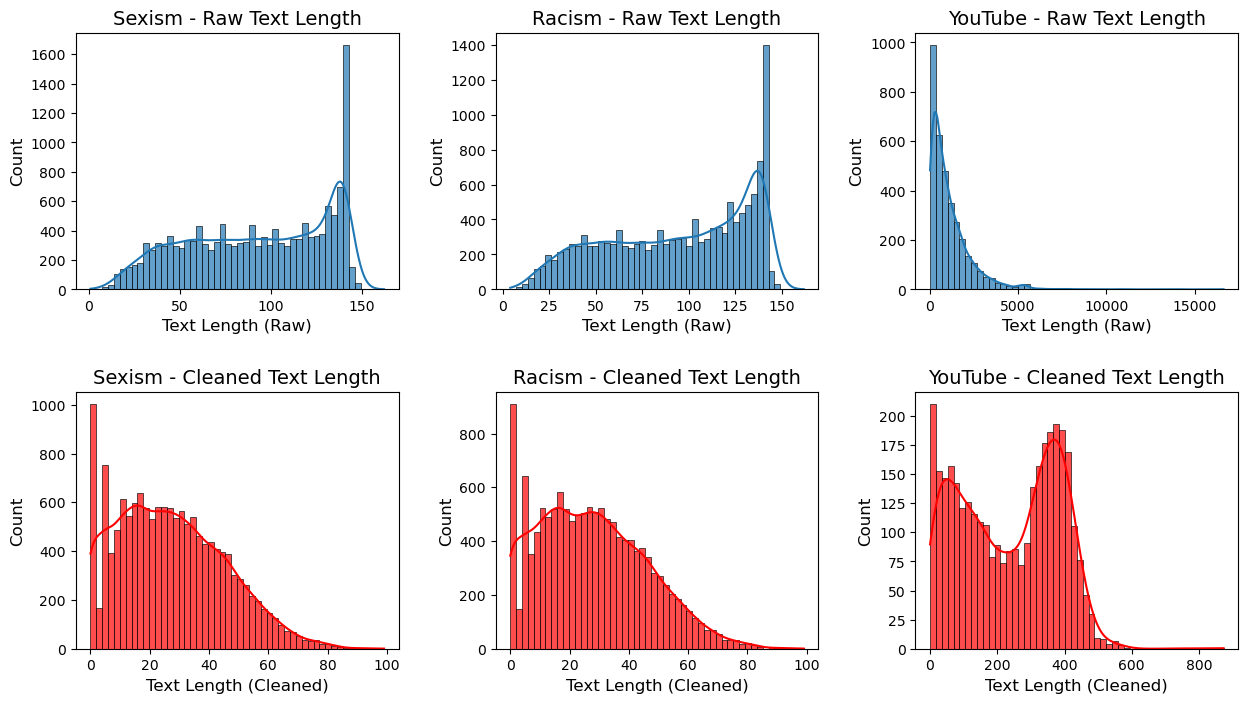

In [8]:
# Define datasets
datasets = {'Sexism': sexism, 'Racism': racism, 'YouTube': youtube}


plt.figure(figsize=(15, 8))

for i, (name, df) in enumerate(datasets.items(), 1):
    df['text_length_raw'] = df['Text'].astype(str).apply(len)
    df['text_length_cleaned'] = df['Text_cleaned'].astype(str).apply(len)

    # Raw text histogram
    plt.subplot(2, 3, i)
    sns.histplot(df['text_length_raw'], bins=50, kde=True, alpha=0.7)
    plt.title(f"{name} - Raw Text Length", fontsize=14)
    plt.xlabel("Text Length (Raw)", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # Cleaned text histogram
    plt.subplot(2, 3, i + 3)
    sns.histplot(df['text_length_cleaned'], bins=50, kde=True, color='red', alpha=0.7)
    plt.title(f"{name} - Cleaned Text Length", fontsize=14)
    plt.xlabel("Text Length (Cleaned)", fontsize=12)
    plt.ylabel("Count", fontsize=12)

# Adjust spacing to prevent overlap
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

### **Average Text Length Before and After Cleaning**

To evaluate the impact of preprocessing, we compare the **average text length** before and after cleaning across all datasets (**Sexism, Racism, YouTube**).

- The bar chart below displays the **average text length** in the raw dataset (before preprocessing) and the cleaned dataset (after preprocessing).
- The **blue bars** represent the raw text length, while the **red bars** represent the cleaned text length.
- The reduction in text length after cleaning results from removing:
  - Stopwords
  - Social media artifacts (mentions, hashtags, links)
  - Punctuation and non-alphabetic characters
  - Unnecessary repetitions

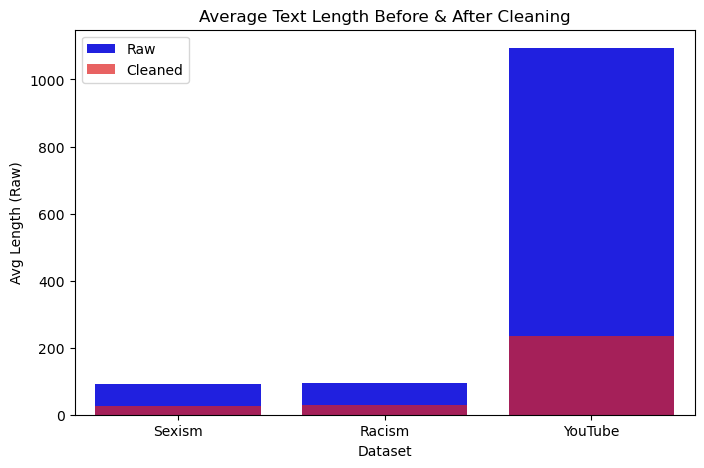

In [9]:
# Average text length comparison
avg_lengths = pd.DataFrame({
    'Dataset': list(datasets.keys()),
    'Avg Length (Raw)': [df['text_length_raw'].mean() for df in datasets.values()],
    'Avg Length (Cleaned)': [df['text_length_cleaned'].mean() for df in datasets.values()]
})

# Plot average lengths
plt.figure(figsize=(8, 5))
sns.barplot(x='Dataset', y='Avg Length (Raw)', data=avg_lengths, color='blue', label='Raw')
sns.barplot(x='Dataset', y='Avg Length (Cleaned)', data=avg_lengths, color='red', alpha=0.7, label='Cleaned')
plt.legend()
plt.title("Average Text Length Before & After Cleaning")
plt.show()

### **Label distribuition**

To understand the balance of neutral vs. harmful content in our datasets, we visualize the **distribution of labels** across the **Sexism, Racism, and YouTube datasets**.

- The bar charts below display the **count of neutral vs. harmful labels** for each dataset.
- The **blue bars** represent **neutral** instances, while the **red bars** represent **harmful** instances.

FileNotFoundError: [Errno 2] No such file or directory: '/Users/polgarcia/Library/Containers/net.whatsapp.WhatsApp/Data/tmp/documents/B922845D-A964-4710-8A52-B3B2FE58B53F/C:\\Users\\marta\\Desktop\\TERM2\\Text_Mining\\hw2/label_distribution.png'

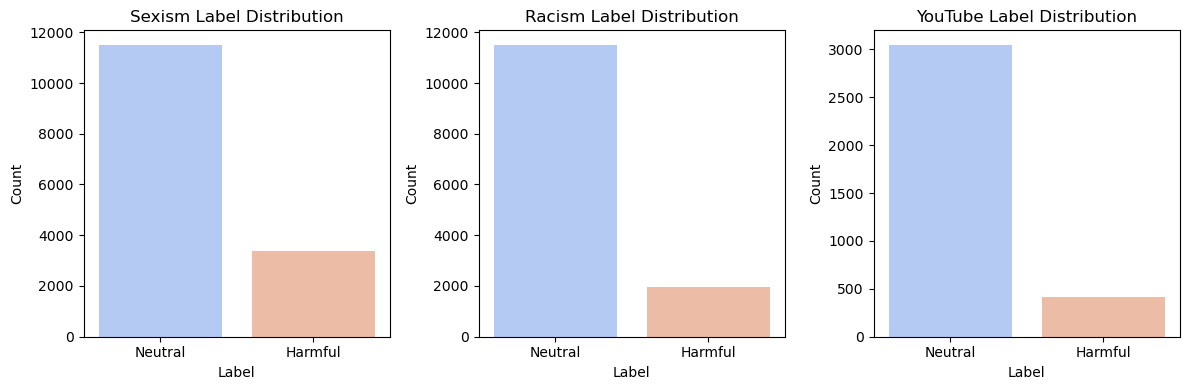

In [10]:
# Define save path
save_path = r"C:\Users\marta\Desktop\TERM2\Text_Mining\hw2"

plt.figure(figsize=(12, 4))

for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df["oh_label"], hue=df["oh_label"], palette="coolwarm", legend=False)
    plt.xticks(ticks=[0, 1], labels=['Neutral', 'Harmful'])
    plt.title(f"{name} Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_path, "label_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()


#### Next, we created a word clouds for each dataset:  **Sexism, Racism, and YouTube**. They provide a visualization of the most frequent words used in the cleaned text from three datasets.  These word clouds exclude stopwords and irrelevant terms to highlight key words in each dataset.

### **Word cloud for the sexism dataset**

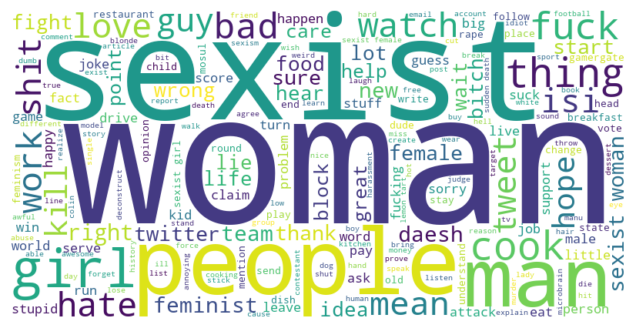

In [ ]:
from wordcloud import STOPWORDS

save_path = r"C:\Users\marta\Desktop\TERM2\Text_Mining\hw2"

# Function to generate and save word cloud
def generate_sexism_wordcloud():
    text = " ".join(sexism["Text_cleaned"].dropna())  # Concatenate all text
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Remove axis labels

    # Save the figure
    save_file = os.path.join(save_path, "sexism_wordcloud.png")
    plt.savefig(save_file, dpi=300, bbox_inches='tight')

    plt.show()

# Call the function
generate_sexism_wordcloud()

### **Word cloud for the racism dataset**

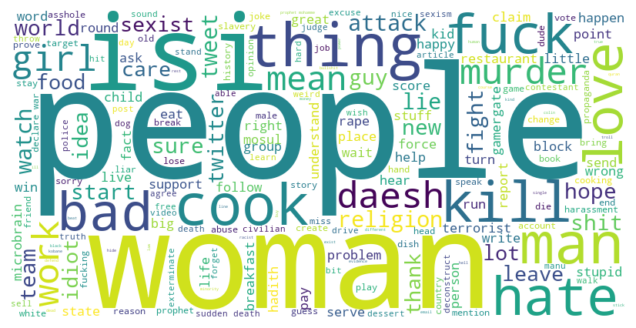

In [ ]:
save_path = r"C:\Users\marta\Desktop\TERM2\Text_Mining\hw2"

# Generate and display word cloud for the Racism dataset
def generate_racism_wordcloud():
    text = " ".join(racism["Text_cleaned"].dropna())  # Concatenate all text
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    # Save the figure
    save_file = os.path.join(save_path, "racism_wordcloud.png")
    plt.savefig(save_file, dpi=300, bbox_inches='tight')

    plt.show()

# Call the function
generate_racism_wordcloud()

### **Word cloud for the Youtube dataset**

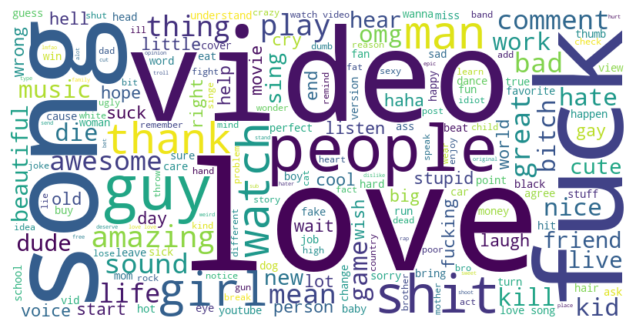

In [ ]:
# Generate and display word cloud for the YouTube dataset
def generate_youtube_wordcloud():
    text = " ".join(youtube["Text_cleaned"].dropna())  # Concatenate all text
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Call the function
generate_youtube_wordcloud()

# 2. Sexism Dictionary

#### Considering that our dataset is labelled, there are two possible approaches we can implement:
- filter for comments that have been labelled as **sexist**, compute the **Document Term Matrix** and retrieve the most frequent words. Indeed, if we only use comments that are already known to be sexist, there is no need to use TF-IDF, since it would lead to penalize words that appear across all documents, but, in this case, if a words appears across all (sexist) documents, it might be a relevant one in detecting this type of cyberbullying, hence, it would have to be included in our dictionary.

- use the **whole dataset** (as if we did not have labels) and apply **TF-IDF**. If we use a whole dataset, we no longer are interested in words that appear across all documents (since, in this case, they would indeed represent just common words), but we are instead interested in distinguishing terms. So here is reasonable to apply TF-IDF and then build the dictionary basing on words that have an higher IDF score. 

We will implement both approaches, and use the first method as benchmark and see how much the second one deviates. 

### 2.1 **Approach 1: filter for sexist comments and define the Document Term Matrix**

In [ ]:
# Filter for negative comments 
aggressive_texts = sexism[sexism['oh_label'] == 1]['Text_cleaned']

# Create Document Term Matrix
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(min_df=0.001, max_df=0.90, ngram_range=(1, 2))
dtm = vectorizer.fit_transform(aggressive_texts)

# Get the features' names
dtm_features = vectorizer.get_feature_names_out()

# Compute absolute frequencies (how many times each term appears)
term_frequencies = np.array(dtm.sum(axis=0)).flatten()

# Create a dataframe with terms and the corresponding frequencies 
dtm_terms = pd.DataFrame({ 'term': dtm_features, 'frequency': term_frequencies})

# Compute percentage frequencies (percentage of documents in which each term appears)
dtm_terms['frequency_pct'] = dtm_terms['frequency'] / len(aggressive_texts) * 100

# Sort by frequency 
dtm_terms = dtm_terms.sort_values('frequency', ascending=False)

# Create the dictionary 
dtm_dictionary = dtm_terms[dtm_terms['frequency_pct'] > 1.0]

# Check the dictionary
print("examples of words in the dictionary:")
print(dtm_dictionary.head(10))
print("number of words in the dictionary:", len(dtm_dictionary))

examples of words in the dictionary:
             term  frequency  frequency_pct
719        sexist        956      28.309150
934         woman        623      18.448327
342          girl        366      10.838022
491           man        262       7.758365
287        female        241       7.136512
746  sexist woman        150       4.441812
299      feminist        125       3.701510
801         sport        105       3.109269
682         right        104       3.079656
73          bitch        101       2.990820
number of words in the dictionary: 53


### 2.2 **Approach 2: use the whole dataset and apply TF-IDF**

In [ ]:
# Implement TF-IDF 
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=0.005, max_df=0.30)
tfidf_matrix = tfidf.fit_transform(sexism['Text_cleaned'])
tfidf_features = tfidf.get_feature_names_out()

# Compute the TF-IDF scores 
avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()

# Create a dataframe with words and corresponding TF-IDF scores 
tfidf_terms = pd.DataFrame({'term': tfidf_features, 'tfidf_score': avg_tfidf})

# Sort by descending TF-IDF score
tfidf_terms = tfidf_terms.sort_values('tfidf_score', ascending=False)

# Filter for words with TF-IDF score > 0.01
tfidf_dictionary = tfidf_terms[tfidf_terms['tfidf_score'] > 0.005]

# Check the dictionary
print("examples of words in the dictionary:")
print(tfidf_dictionary.head(10))
print("number of words in the dictionary:", len(tfidf_dictionary))

examples of words in the dictionary:
       term  tfidf_score
105   woman     0.035775
81   sexist     0.034550
68   people     0.024387
34     girl     0.023660
61      man     0.019765
97    thing     0.015101
12     cook     0.015017
30     fuck     0.014159
2       bad     0.012293
59     love     0.011698
number of words in the dictionary: 67


#### Common words between the twe DTM dictionary and the TF-IDF one

In [ ]:
common_terms = set(dtm_dictionary['term']) & set(tfidf_dictionary['term'])
print(f"\n number of common words across the two dictionaries: {len(common_terms)}")
print("examples of commond words:", list(common_terms)[:20])


 number of common words across the two dictionaries: 32
examples of commond words: ['bitch', 'work', 'hope', 'female', 'game', 'girl', 'drive', 'male', 'guy', 'hear', 'fuck', 'tweet', 'mean', 'great', 'man', 'sexist woman', 'right', 'stupid', 'cook', 'care']


# 3. Racism Dataset

#### We will implement the same logic as before, meaning that we will create two different dictionaries: 
- one basing on DTM and the subset of data that has been flagged as racist
- one with TF-IDF and the whole dataset. 

Additionally, since the examples of racism in our sample are primarily related to **Islamophobia**, it is challenging to distinguish between actual racism and general comments or tweets about Islam-related topics.

To address this issue, we initially considered retrieving only **bigrams**, allowing our dictionary to detect instances where an Islam-related word is associated with an offensive term. We tested this approach (and present the corresponding results below), but it resulted in a very limited dictionary, which was hardly useful for detecting racism.

After this attempt, we decided to include **both single words and bigrams** to build a broader dictionary, capable of capturing not only Islamophobia but also other forms of racism across different corpora.

### 3.1 **Approach 1: filter for racist comments and define the Document Term Matrix**

#### Create a dictionary with only biagrams

In [ ]:
# Filter for negative comments 
racist_texts = racism[racism['oh_label'] == 1]['Text_cleaned']

# Create Document Term Matrix
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=1, max_df=0.90)
dtm = vectorizer.fit_transform(racist_texts)

# Get the features' names
dtm_features2 = vectorizer.get_feature_names_out()

# Compute absolute frequencies (how many times each term appears)
term_frequencies2 = np.array(dtm.sum(axis=0)).flatten()

# Create a dataframe with terms and the corresponding frequencies 
dtm_terms2 = pd.DataFrame({ 'term': dtm_features2, 'frequency': term_frequencies2})

# Compute percentage frequencies (percentage of documents in which each term appears)
dtm_terms2['frequency_pct'] = dtm_terms2['frequency'] / len(racist_texts) * 100

# Sort by frequency 
dtm_terms2 = dtm_terms2.sort_values('frequency', ascending=False)

# Create the dictionary with only biagrams
dtm_dic_biagrams = dtm_terms2[dtm_terms2['frequency_pct'] > 0.5]

# Check the dictionary 
print("examples of biagrams in the dictionary:")
print(dtm_dic_biagrams.head(10))
print("number of words in the dictionary:", len(dtm_dic_biagrams))

examples of biagrams in the dictionary:
                   term  frequency  frequency_pct
1461        declare war         53       2.690355
4915    prophet mohamme         43       2.182741
4471  pedophile prophet         29       1.472081
6667       war humanity         20       1.015228
6792        woman child         17       0.862944
5015       quran hadith         17       0.862944
5781       slave trader         15       0.761421
5111         rape slave         14       0.710660
5754         slave girl         13       0.659898
2565      hatred murder         10       0.507614
number of words in the dictionary: 11


#### Create a dictionary with unigrams and biagrams

In [ ]:
# Create Document Term Matrix
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.90)
dtm = vectorizer.fit_transform(racist_texts)

# Get the features' names
dtm_features2 = vectorizer.get_feature_names_out()

# Compute absolute frequencies (how many times each term appears)
term_frequencies2 = np.array(dtm.sum(axis=0)).flatten()

# Create a dataframe with terms and the corresponding frequencies 
dtm_terms2 = pd.DataFrame({ 'term': dtm_features2, 'frequency': term_frequencies2})

# Compute percentage frequencies (percentage of documents in which each term appears)
dtm_terms2['frequency_pct'] = dtm_terms2['frequency'] / len(racist_texts) * 100

# Sort by frequency 
dtm_terms2 = dtm_terms2.sort_values('frequency', ascending=False)

# Create the dictionary with unigrams and biagrams 
dtm_dictionary2 = dtm_terms2[dtm_terms2['frequency_pct'] > 1]

# Check the dictionary with unigrams and biagrams
print("examples of words in the dictionary:")
print(dtm_dictionary2.head(10))
print("number of words in the dictionary:", len(dtm_dictionary2))

examples of words in the dictionary:
           term  frequency  frequency_pct
5439     murder        182       9.238579
6969   religion        152       7.715736
6541    prophet        135       6.852792
4146       isis        134       6.802030
6017     people        125       6.345178
9064      woman        115       5.837563
8892        war         89       4.517766
8314  terrorist         87       4.416244
4406       kill         84       4.263959
7669      slave         82       4.162437
number of words in the dictionary: 90


### 3.2 **Approach 2: use the whole dataset and apply TF-IDF**

#### Create a dictionary with only biagrams

In [ ]:
# Implement TF-IDF 
tfidf2 = TfidfVectorizer(ngram_range=(2,2), min_df=0.001, max_df=0.30)
tfidf_matrix2 = tfidf2.fit_transform(racism['Text_cleaned'])
tfidf_features2 = tfidf2.get_feature_names_out()

# Compute the TF-IDF scores 
avg_tfidf2 = np.array(tfidf_matrix2.mean(axis=0)).flatten()

# Create a dataframe with words and corresponding TF-IDF scores 
tfidf_terms2 = pd.DataFrame({'term': tfidf_features2, 'tfidf_score': avg_tfidf2})

# Sort by descending TF-IDF score
tfidf_terms2 = tfidf_terms2.sort_values('tfidf_score', ascending=False)

# Create the dictionary with only biagrams
tfidf_dic_biagrams= tfidf_terms2[tfidf_terms2['tfidf_score'] > 0.001]

# Check the dictionary 
print("examples of bigrams in the dictionary:")
print(tfidf_dic_biagrams.head(10))
print("number of bigrams in the dictionary:", len(tfidf_dic_biagrams))

examples of bigrams in the dictionary:
                 term  tfidf_score
21       sudden death     0.003984
13    prophet mohamme     0.003346
5         declare war     0.003329
16   restaurant round     0.002575
10         lemon tart     0.002500
12  pedophile prophet     0.002031
14       quran hadith     0.002024
0         ash camilla     0.002004
25         woman tech     0.002004
9        kitchen rule     0.001868
number of bigrams in the dictionary: 26


#### Create a dictionary with unigrams and biagrams

In [ ]:
# Implement TF-IDF 
tfidf2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix2 = tfidf2.fit_transform(racism['Text_cleaned'])
tfidf_features2 = tfidf2.get_feature_names_out()

# Compute the TF-IDF scores 
avg_tfidf2 = np.array(tfidf_matrix2.mean(axis=0)).flatten()

# Create a dataframe with words and corresponding TF-IDF scores 
tfidf_terms2 = pd.DataFrame({'term': tfidf_features2, 'tfidf_score': avg_tfidf2})

# Sort by descending TF-IDF score
tfidf_terms2 = tfidf_terms2.sort_values('tfidf_score', ascending=False)

# Create the dictionary with unigrams and biagrams
tfidf_dictionary2= tfidf_terms2[tfidf_terms2['tfidf_score'] > 0.0015]

# Check the dictionary 
print("examples of words in the dictionary:")
print(tfidf_dictionary2.head(10))
print("number of words in the dictionary:", len(tfidf_dictionary2))

examples of words in the dictionary:
         term  tfidf_score
29018  people     0.007674
44855   woman     0.006305
15647    fuck     0.004890
8169     cook     0.004886
20906    isis     0.004740
40902   thing     0.004709
23889    love     0.004492
2654      bad     0.004123
18027    hate     0.004053
16456    girl     0.004002
number of words in the dictionary: 97


In [ ]:
file_path = r"C:\Users\marta\Desktop\TERM2\Text_Mining\hw2\tfidf_dictionary.csv"

# Exporting the dictionary to a CSV file at the specified path
tfidf_dictionary2.to_csv(file_path, index=False)

print(f"Dictionary saved at: {file_path}")

Dictionary saved at: C:\Users\marta\Desktop\TERM2\Text_Mining\hw2\tfidf_dictionary.csv


#### Common words between the twe DTM dictionary and the TF-IDF one - we compare full dictionaries, with unigrams and biagrams

In [ ]:
common_terms2 = set(dtm_dictionary2['term']) & set(tfidf_dictionary2['term'])
print(f"\n number of common words across the two dictionaries: {len(common_terms2)}")
print("examples of commond words:", list(common_terms2)[:20])


 number of common words across the two dictionaries: 44
examples of commond words: ['claim', 'head', 'understand', 'rape', 'girl', 'death', 'live', 'attack', 'idiot', 'quran', 'isis', 'liar', 'religion', 'war', 'follow', 'mean', 'start', 'man', 'right', 'stupid']


# 4. Visual Representation

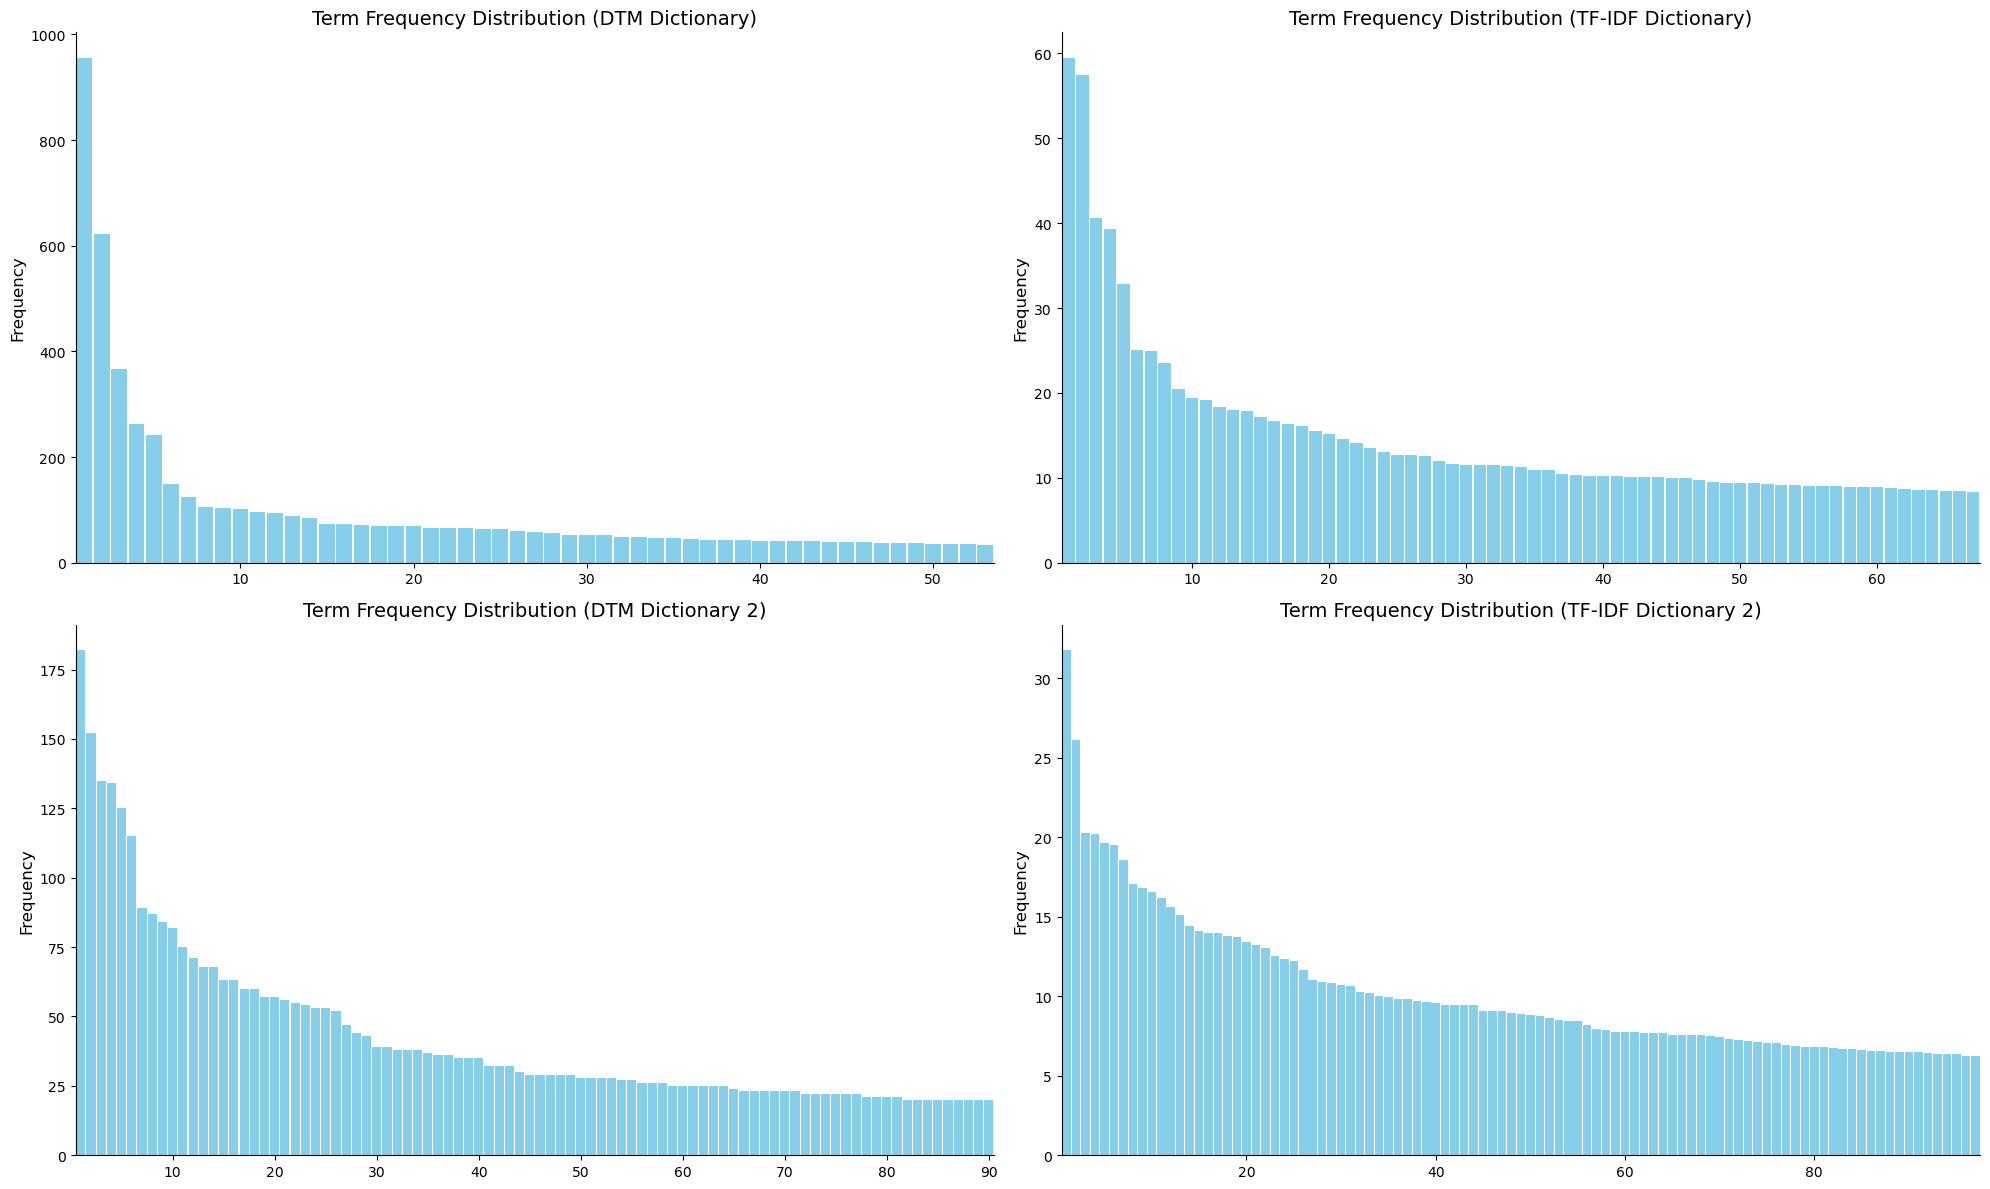

In [ ]:
# We create the column 'id' to order terms in the x axis
def add_numeric_id(df):
    df = df.copy()  # Evita il SettingWithCopyWarning
    df['id'] = range(1, len(df) + 1)
    return df

# Applica la funzione ai tuoi dizionari
dtm_dictionary = add_numeric_id(dtm_dictionary)
tfidf_dictionary = add_numeric_id(tfidf_dictionary)
dtm_dictionary2 = add_numeric_id(dtm_dictionary2)
tfidf_dictionary2 = add_numeric_id(tfidf_dictionary2)

# Define dictionaries (assuming they are DataFrames with 'id' and 'frequency' columns)
dictionaries = {
    "DTM Dictionary": dtm_dictionary,
    "TF-IDF Dictionary": tfidf_dictionary,
    "DTM Dictionary 2": dtm_dictionary2,
    "TF-IDF Dictionary 2": tfidf_dictionary2
}

# Calcola la frequenza normalizzando i punteggi TF-IDF
def compute_frequency(tfidf_df):
    if tfidf_df is not None and 'tfidf_score' in tfidf_df.columns:
        tfidf_df['frequency'] = (tfidf_df['tfidf_score'] / tfidf_df['tfidf_score'].sum()) * 1000
        tfidf_df['id'] = range(1, len(tfidf_df) + 1)

# Esegui la funzione su entrambi i dizionari TF-IDF
compute_frequency(tfidf_dictionary)
compute_frequency(tfidf_dictionary2)

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the dictionaries and create plots
for ax, (title, dictionary) in zip(axes, dictionaries.items()):
    V = dictionary.shape[0]
    x_ids = dictionary['id']
    frequencies = dictionary['frequency']

    ax.bar(x_ids, frequencies, width=0.9, color='skyblue', align='center')
    ax.set_title(f'Term Frequency Distribution ({title})', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)

    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set x-axis limits
    ax.set_xlim(0.5, V + 0.5)

    # Ensure y-axis ticks are visible and appropriately sized
    ax.tick_params(axis='y', labelsize=10)

# Optimize layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# 5. Youtube Dataset

### 5.1 **Detect cyberbullying in youtube comments with the dictionaries we built**

In [ ]:
def analyze_youtube_comments(youtube_df, sexism_dict, racism_dict, threshold=5):
   # Create a copy to avoid overwriting previous results. Each call to the function will use a new copy of the dataset
    df = youtube_df.copy()
    
    # Initialize classification columns
    df['is_sexist'] = False
    df['is_racist'] = False
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # Split preprocessed text into words and bigrams
        words = row['Text_cleaned'].split()
        bigrams = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
        
        # Count matches in dictionaries for both unigrams and bigrams
        sexist_matches = sum(1 for word in words if word in sexism_dict['term'].values) + \
                        sum(1 for bigram in bigrams if bigram in sexism_dict['term'].values)
        
        racist_matches = sum(1 for word in words if word in racism_dict['term'].values) + \
                        sum(1 for bigram in bigrams if bigram in racism_dict['term'].values)
        
        # Flag comment if the number of matches is greater than threshold
        df.at[idx, 'is_sexist'] = sexist_matches >= threshold
        df.at[idx, 'is_racist'] = racist_matches >= threshold
    
    return df

# Analyze sexism using DTM-based dictionary
results_sexism_dtm = analyze_youtube_comments(
    youtube,
    sexism_dict=dtm_dictionary,
    racism_dict=dtm_dictionary2)  # Default threshold=5

# Analyze sexism using TF-IDF-based dictionary
results_sexism_tfidf = analyze_youtube_comments(
    youtube,
    sexism_dict=tfidf_dictionary,
    racism_dict=tfidf_dictionary2)  # Default threshold=5

print("\nDetecting sexism:")
print(f"Total comments analyzed: {len(youtube)}")
print(f"Sexist comments with DTM: {results_sexism_dtm['is_sexist'].sum()}")
print(f"Sexist comments with TF-IDF: {results_sexism_tfidf['is_sexist'].sum()}")
total = len(youtube)
sexism_pct_DTM = (results_sexism_dtm['is_sexist'].sum() / total) * 100
sexism_pct_TFIDF = (results_sexism_tfidf['is_sexist'].sum() / total) * 100
print(f"\nPercentages:")
print(f"DTM: {sexism_pct_DTM:.2f}%")
print(f"TF-IDF: {sexism_pct_TFIDF:.2f}%")

# Analyze racism using DTM-based dictionary
results_racism_dtm = analyze_youtube_comments(
    youtube,
    sexism_dict=dtm_dictionary2,
    racism_dict=dtm_dictionary2)  # Using default threshold=5

# Analyze racism using TF-IDF-based dictionary
results_racism_tfidf = analyze_youtube_comments(
    youtube,
    sexism_dict=tfidf_dictionary2,
    racism_dict=tfidf_dictionary2)  # Using default threshold=5

print("\nDetecting racism:")
print(f"Total comments analyzed: {len(youtube)}")
print(f"Racist comments with DTM: {results_racism_dtm['is_racist'].sum()}")
print(f"Racist comments with TF-IDF: {results_racism_tfidf['is_racist'].sum()}")
racist_pct_DTM = (results_racism_dtm['is_racist'].sum() / total) * 100
racist_pct_TFIDF = (results_racism_tfidf['is_racist'].sum() / total) * 100
print(f"\nPercentages:")
print(f"DTM: {racist_pct_DTM:.2f}%")
print(f"TF-IDF: {racist_pct_TFIDF:.2f}%")

# Analyze racism using bigrams-only dictionaries 
# DTM
results_bigrams_dtm = analyze_youtube_comments(
    youtube,
    sexism_dict=dtm_dic_biagrams,
    racism_dict=dtm_dic_biagrams,
    threshold=1)  # Lower threshold due to fewer bigram matches

# TF-IDF
results_bigrams_tfidf = analyze_youtube_comments(
    youtube,
    sexism_dict=tfidf_dic_biagrams,
    racism_dict=tfidf_dic_biagrams,
    threshold=1)  # Lower threshold due to fewer bigram matches

print("\nDetecting racism - bigrams only:")
print(f"Total comments analyzed: {len(youtube)}")
print(f"Racist comments DTM: {results_bigrams_dtm['is_racist'].sum()}")
print(f"Racist comments TF-IDF: {results_bigrams_tfidf['is_racist'].sum()}")
bi_pct_DTM = (results_bigrams_dtm['is_racist'].sum() / total) * 100
bi_pct_TFIDF = (results_bigrams_tfidf['is_racist'].sum() / total) * 100
print(f"\nPercentages:")
print(f"DTM: {bi_pct_DTM:.2f}%")
print(f"TF-IDF: {bi_pct_TFIDF:.2f}%")

100%|██████████| 3464/3464 [00:06<00:00, 524.61it/s]



Detecting sexism:
Total comments analyzed: 3464
Sexist comments with DTM: 1369
Sexist comments with TF-IDF: 1969

Percentages:
DTM: 39.52%
TF-IDF: 56.84%


100%|██████████| 3464/3464 [00:06<00:00, 526.19it/s]



Detecting racism:
Total comments analyzed: 3464
Racist comments with DTM: 729
Racist comments with TF-IDF: 2088

Percentages:
DTM: 21.05%
TF-IDF: 60.28%


100%|██████████| 3464/3464 [00:05<00:00, 579.64it/s]


Detecting racism - bigrams only:
Total comments analyzed: 3464
Racist comments DTM: 8
Racist comments TF-IDF: 32

Percentages:
DTM: 0.23%
TF-IDF: 0.92%
